In [118]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [120]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [121]:
#Specifying the paramenters of our model
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [122]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:33061056512.0
Coefficients:  tensor([[34.6054,  0.1024,  0.1131,  0.9827,  5.1787]])
-------------------
2th epoch
Loss ols:38351495168.0
Coefficients:  tensor([[70.0148,  0.1286,  0.1380,  1.3171,  9.5032]])
-------------------
3th epoch
Loss ols:30489061376.0
Coefficients:  tensor([[102.6837,   0.1565,   0.1644,   2.0158,  13.7932]])
-------------------
4th epoch
Loss ols:34685460480.0
Coefficients:  tensor([[136.4289,   0.1850,   0.1874,   2.4160,  18.6065]])
-------------------
5th epoch
Loss ols:nan
Coefficients:  tensor([[nan, nan, nan, nan, nan]])


In [123]:
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [124]:
#Loading in complex MNIST train and test datasets while transforming them to 64
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

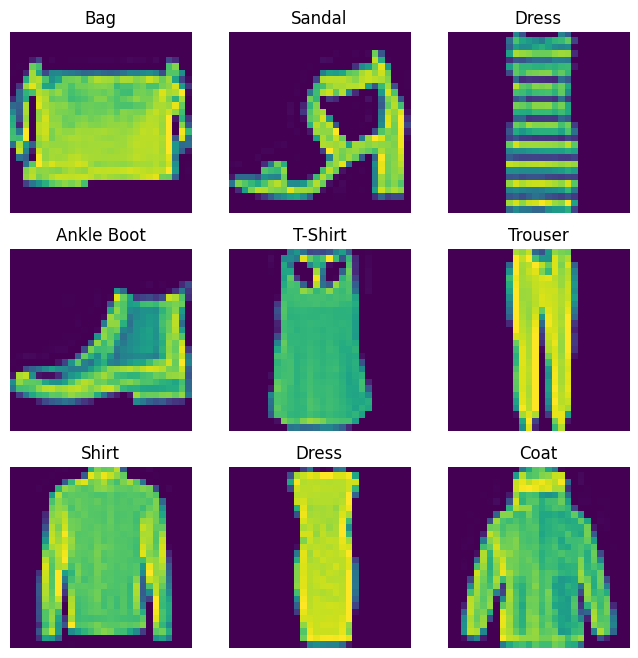

In [178]:
#Visualizing 9 random examples

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()



In [126]:
#Splitting our data into batch sizes
mnist_batch_size = 50

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [127]:
#Creating the model and initializing the weights
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

In [190]:
#Creating a class for displaying the results
class evaluation:
    """For evaluating the accuracy of image recognition neural networks which use Cross-Entropy Loss"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.net = net
        self.img = img
        self.label = label
    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(img).double()
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities
    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred
    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)
    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != label)/len(self.label)
    def add(self,img,label):
        """Appends an error rate to the history of error rates (used for in-sample error rate during training)"""
        self.img = img
        self.label = label
        self.hist.append(self.error())
    def __getitem__(self, idx):
        return self.hist[idx]

In [195]:
num_epochs = 50
ev = evaluation(net = logit_net)
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    logit_net.train()
    logit_net.zero_grad()
    global img, label
    img, label = next(iter(mnist_train_iter))
    output = logit_net(img)

    l = logit_loss(output,label)


    l.mean().backward(retain_graph=True)

    logit_trainer.step()
    ev.add(img,label)
    print("In-sample error rate:",ev.error())
    print("Certainty:",ev.cert())






-------------------
1th epoch
In-sample error rate: tensor(0.2800)
Certainty: tensor([0.4090, 0.1857, 0.2700, 0.3312, 0.5770, 0.3365, 0.2091, 0.5096, 0.1693,
        0.8517, 0.8603, 0.9109, 0.3141, 0.3271, 0.4388, 0.3578, 0.7354, 0.2231,
        0.4875, 0.7663, 0.2079, 0.6308, 0.5415, 0.5075, 0.7181, 0.5392, 0.6748,
        0.3026, 0.4609, 0.3042, 0.5434, 0.1598, 0.5754, 0.2914, 0.5877, 0.7414,
        0.4841, 0.7590, 0.8390, 0.4777, 0.4012, 0.5927, 0.3395, 0.2643, 0.6200,
        0.2659, 0.3700, 0.1990, 0.6754, 0.6035], dtype=torch.float64,
       grad_fn=<AmaxBackward0>)
-------------------
2th epoch
In-sample error rate: tensor(0.3400)
Certainty: tensor([0.7671, 0.4364, 0.2542, 0.6015, 0.4496, 0.2386, 0.6357, 0.4808, 0.3522,
        0.8856, 0.7155, 0.6036, 0.2357, 0.7951, 0.1864, 0.5314, 0.2850, 0.2229,
        0.2835, 0.2608, 0.2093, 0.6435, 0.4792, 0.4463, 0.6595, 0.3874, 0.7995,
        0.8005, 0.3214, 0.5006, 0.2361, 0.4479, 0.2641, 0.4403, 0.3847, 0.4004,
        0.3613, 0.5102